# Necessary Libraries

In [267]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [164]:
!pip install -q openpyxl

# Data Reading from the files

In [208]:
customers = pd.read_csv('kaggle competiton/customers.csv', delimiter=';')
customers.head(4)

,Unnamed: 0,ID,Contract_Start,Contract_End,Gender,Location,PT,Usual_Visit_Time,Income Level
0,1,1993-199842,Nov-15,Apr-16,Female,Karlsruhe,no,17:15:00,3
1,2,1980-85660,Apr-14,Jul-14,Female,Nuremberg,yes,18:15:00,3
2,3,1973-147412,May-15,May-15,Male,Berlin,yes,NaN,4
3,4,1969-49802,Jun-18,Sep-18,Female,Braunschweig,no,06:45:00,5


In [166]:
customers.isna().sum()

Unnamed: 0            0
ID                    0
Contract_Start        0
Contract_End          0
Gender                0
Location              0
PT                    0
Usual_Visit_Time    941
Income Level          0
dtype: int64

We will replace the missing values in the usual_Visit_Time once we merge the datasets together

In [167]:
customers.duplicated().sum()

0

In [168]:
prices = pd.read_excel('kaggle competiton/prices.xlsx')
prices.head(4)

,Year,Price
0,2009,30.99
1,2010,30.99
2,2011,30.99
3,2012,30.99


In [169]:
prices.isna().sum()

Year     0
Price    0
dtype: int64

In [170]:
visits = pd.read_csv('kaggle competiton/visits.csv')
visits.head(4)

,Unnamed: 0,CustomerID,year_week,Visits
0,1,1.0,2011 - 48,2
1,2,1.0,2011 - 49,4
2,3,1.0,2011 - 50,6
3,4,1.0,2011 - 51,5


In [171]:
visits.isna().sum()

Unnamed: 0    0
CustomerID    0
year_week     0
Visits        0
dtype: int64

In [172]:
visits.duplicated().sum()

0

In [218]:
#Split the 'year_week' column into 'Year' and 'Week' columns
visits[['Year', 'Week']] = visits['year_week'].str.split('-', expand=True)
visits['Year'] = visits['Year'].astype(int)
visits['Week'] = visits['Week'].astype(int)

# Merge customers and visits

Merge the Customers and Visits dataset together on the bases of the customerId

1980-191885	 This is an example of Id from customers dataset where first part is birth year and second part id random number 

the second part comparable with the customerId in the visits and we will merge the datasets on the bases of this

In [219]:
customers['CustomerID'] = customers['ID'].apply(lambda x: x.split('-')[1]).astype(float)
merged_data = pd.merge(customers, visits, left_on='CustomerID', right_on='CustomerID', how='left')

In [220]:
merged_data.drop(columns=['Unnamed: 0_x','Unnamed: 0_y'],inplace=True)

In [221]:
merged_data.drop(columns=['CustomerID'],inplace=True)

In [222]:
merged_data.head(3)

,ID,Contract_Start,Contract_End,Gender,Location,PT,Usual_Visit_Time,Income Level,year_week,Visits,Year,Week
0,1993-199842,Nov-15,Apr-16,Female,Karlsruhe,no,17:15:00,3,2015 - 44,2.0,2015.0,44.0
1,1993-199842,Nov-15,Apr-16,Female,Karlsruhe,no,17:15:00,3,2015 - 45,4.0,2015.0,45.0
2,1993-199842,Nov-15,Apr-16,Female,Karlsruhe,no,17:15:00,3,2015 - 46,4.0,2015.0,46.0


# Merge merged_data and prices

In [223]:
# first we need to convert the date in the proper date format in both start and end of the contract

In [224]:
merged_data['Contract_Start'] = pd.to_datetime(merged_data['Contract_Start'], format='%b-%y')
merged_data['Contract_End'] = merged_data['Contract_End'].replace('n.a.', pd.NaT)
merged_data['Contract_End'] = pd.to_datetime(merged_data['Contract_End'], format='%b-%y', errors='coerce')

In [225]:
# Now we will merge the price and merged_data on the bases of Year in prices and Contract_start on merged_data

In [226]:
merged_data['Start_Year'] = merged_data['Contract_Start'].dt.year
final_merged_data = pd.merge(merged_data, prices, left_on='Start_Year', right_on='Year', how='left')

In [227]:
final_merged_data.sample(4)

,ID,Contract_Start,Contract_End,Gender,Location,PT,Usual_Visit_Time,Income Level,year_week,Visits,Year_x,Week,Start_Year,Year_y,Price
2671911,1995-161225,2013-09-01,2013-11-01,Male,Essen,no,18:30:00,3,2013 - 40,3.0,2013.0,40.0,2013,2013.0,30.99
527960,1974-53678,2014-10-01,2015-04-01,Female,Bielefeld,no,16:45:00,3,2015 - 14,5.0,2015.0,14.0,2014,2014.0,30.99
2102181,1984-39966,2018-01-01,2018-11-01,Male,Bielefeld,no,10:15:00,3,2018 - 43,1.0,2018.0,43.0,2018,2018.0,36.99
3272267,1987-143420,2014-12-01,2015-03-01,Female,Stuttgart,no,18:30:00,2,2015 - 4,6.0,2015.0,4.0,2014,2014.0,30.99


# Removing Less Important columns

In [228]:
final_merged_data = final_merged_data.drop(columns=['year_week', 'Year_x', 'Week', 'Year_y'])

In [229]:
final_merged_data.sample(3)

,ID,Contract_Start,Contract_End,Gender,Location,PT,Usual_Visit_Time,Income Level,Visits,Start_Year,Price
424550,1982-84234,2017-10-01,2018-05-01,Male,Berlin,no,15:15:00,4,5.0,2017,36.99
1101772,1976-13480,2011-10-01,2012-07-01,Female,Berlin,no,20:15:00,3,3.0,2011,30.99
2255626,1980-39752,2013-11-01,2014-03-01,Male,Hamburg,no,17:15:00,4,2.0,2013,30.99


# Adding Membership period and Churn Columns

Add a churn column based on whether there is contract date of not 

Add membership period column the customer who are available I assume the current year to be '2019-12-31' 


In [230]:
final_merged_data['Churn'] = final_merged_data['Contract_End'].notna().astype(int)
# Create a 'Membership_Duration' column
final_merged_data['Membership_Duration'] = (final_merged_data['Contract_End'] - final_merged_data['Contract_Start']).dt.days
# Fill NaT values in 'Membership_Duration' with ongoing membership duration
current_date = pd.to_datetime('2019-12-31')
final_merged_data['Membership_Duration'] = final_merged_data['Membership_Duration'].fillna((current_date - final_merged_data['Contract_Start']).dt.days)

In [231]:
final_merged_data.head(4)

,ID,Contract_Start,Contract_End,Gender,Location,PT,Usual_Visit_Time,Income Level,Visits,Start_Year,Price,Churn,Membership_Duration
0,1993-199842,2015-11-01,2016-04-01,Female,Karlsruhe,no,17:15:00,3,2.0,2015,30.99,1,152.0
1,1993-199842,2015-11-01,2016-04-01,Female,Karlsruhe,no,17:15:00,3,4.0,2015,30.99,1,152.0
2,1993-199842,2015-11-01,2016-04-01,Female,Karlsruhe,no,17:15:00,3,4.0,2015,30.99,1,152.0
3,1993-199842,2015-11-01,2016-04-01,Female,Karlsruhe,no,17:15:00,3,2.0,2015,30.99,1,152.0


In [232]:
final_merged_data['Churn'].value_counts()

Churn
1    3978989
0     267462
Name: count, dtype: int64

# Removing some Columns

As we have derived membership period,churn and start date from Contract_Start and Contract_End
we can afford to drop them 

In [233]:
final_merged_data.drop(columns=['Contract_Start','Contract_End'],inplace=True)

# Imputation

We have one column which has missing and the column is Usual_Visit_Time

In [234]:
si = SimpleImputer(strategy='most_frequent')

In [235]:
si.fit(final_merged_data[['Usual_Visit_Time']])

SimpleImputer(strategy='most_frequent')

In [236]:
imputed_data = si.transform(final_merged_data[['Usual_Visit_Time']]).flatten()

In [237]:
final_merged_data['Usual_Visit_Time'] = imputed_data

In [238]:
# we will use mean for visits and price columns

In [239]:
s2 = SimpleImputer(strategy='mean')

In [240]:
imputed_data2 = s2.fit_transform(final_merged_data[['Price']]).flatten()

In [241]:
final_merged_data['Price'] = imputed_data2

In [242]:
# now we will impute the visits column
imputed_data3 = s2.fit_transform(final_merged_data[['Visits']]).flatten()
final_merged_data['Visits'] = imputed_data3

In [243]:
final_merged_data.isna().sum()

ID                     0
Gender                 0
Location               0
PT                     0
Usual_Visit_Time       0
Income Level           0
Visits                 0
Start_Year             0
Price                  0
Churn                  0
Membership_Duration    0
dtype: int64

# Univarite Analysis

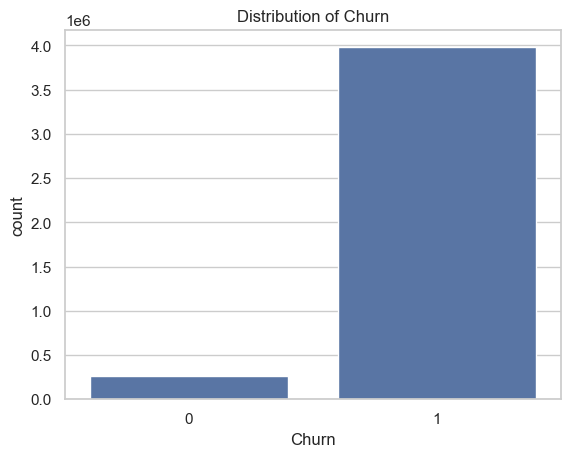

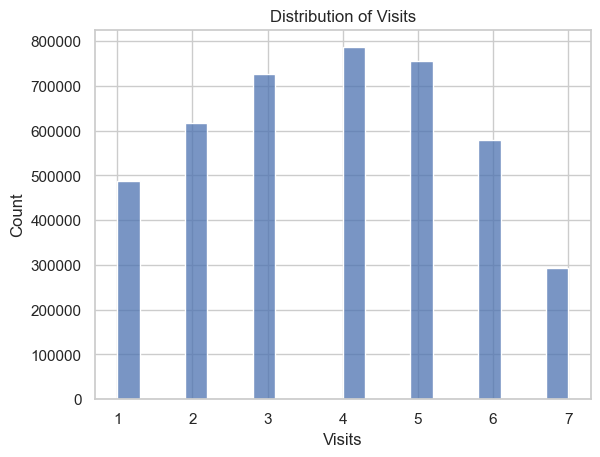

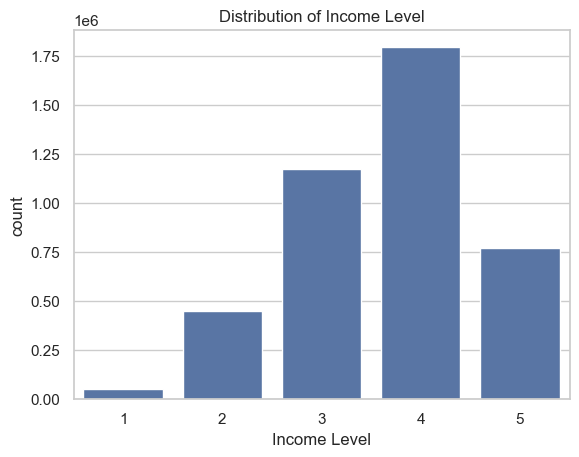

In [244]:
# Distribution of Churn
sns.countplot(data=final_merged_data, x='Churn')
plt.title('Distribution of Churn')
plt.show()

# Distribution of Visits
sns.histplot(data=final_merged_data, x='Visits', bins=20)
plt.title('Distribution of Visits')
plt.show()

# Distribution of Income Level
sns.countplot(data=final_merged_data, x='Income Level')
plt.title('Distribution of Income Level')
plt.show()

# Bivariate Analysis


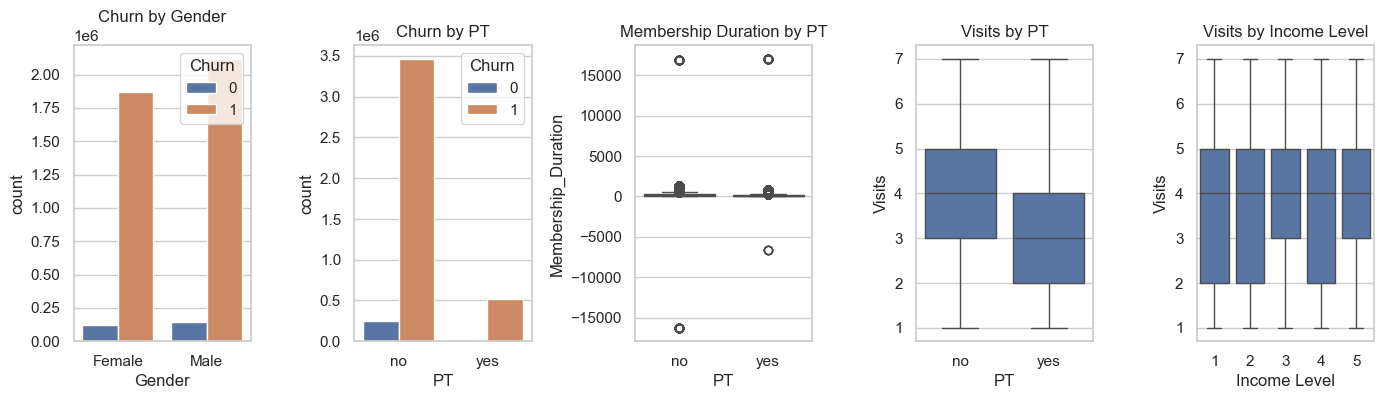

In [245]:
plt.figure(figsize=(14, 4))

# Churn by Gender
plt.subplot(1, 5, 1)
sns.countplot(data=final_merged_data, x='Gender', hue='Churn')
plt.title('Churn by Gender')

# Churn by PT
plt.subplot(1, 5, 2)
sns.countplot(data=final_merged_data, x='PT', hue='Churn')
plt.title('Churn by PT')

# Membership Duration by PT
plt.subplot(1, 5, 3)
sns.boxplot(data=final_merged_data, x='PT', y='Membership_Duration')
plt.title('Membership Duration by PT')

# Visits by PT
plt.subplot(1, 5, 4)
sns.boxplot(data=final_merged_data, x='PT', y='Visits')
plt.title('Visits by PT')

# Visits by Income Level
plt.subplot(1, 5, 5)
sns.boxplot(data=final_merged_data, x='Income Level', y='Visits')
plt.title('Visits by Income Level')

plt.tight_layout()
plt.show()

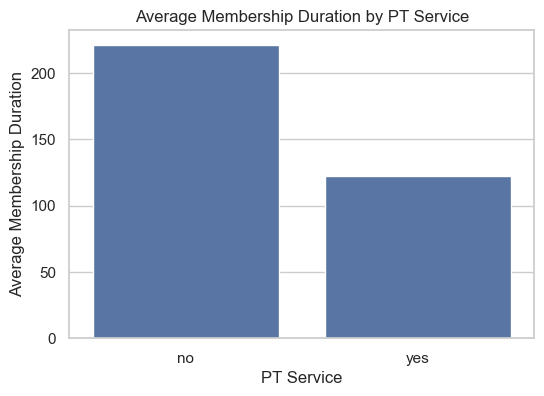

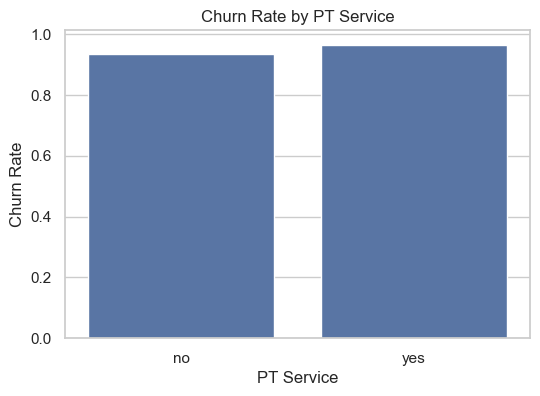

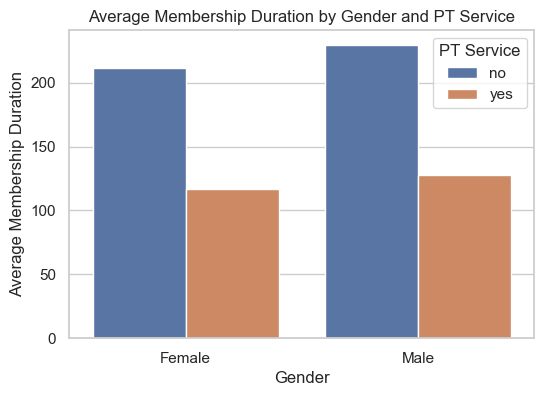

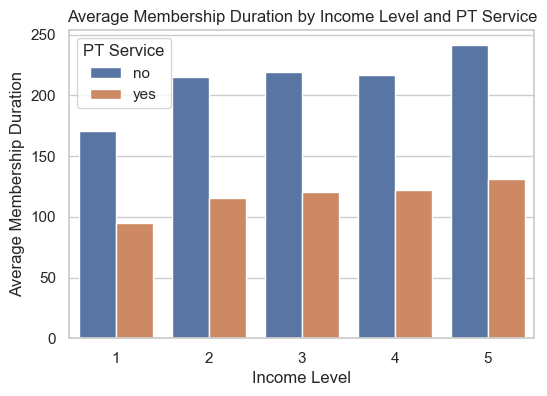

In [246]:
# Bar Plot for Average Membership Duration by PT Service
plt.figure(figsize=(6, 4))
avg_duration_by_pt = final_merged_data.groupby('PT')['Membership_Duration'].mean().reset_index()
sns.barplot(data=avg_duration_by_pt, x='PT', y='Membership_Duration')
plt.title('Average Membership Duration by PT Service')
plt.xlabel('PT Service')
plt.ylabel('Average Membership Duration')
plt.show()

# Bar Plot for Churn Rate by PT Service
plt.figure(figsize=(6, 4))
churn_rate_by_pt = final_merged_data.groupby('PT')['Churn'].mean().reset_index()
sns.barplot(data=churn_rate_by_pt, x='PT', y='Churn')
plt.title('Churn Rate by PT Service')
plt.xlabel('PT Service')
plt.ylabel('Churn Rate')
plt.show()

# Bar Plot for Average Membership Duration by Gender and PT Service
plt.figure(figsize=(6, 4))
avg_duration_by_gender_pt = final_merged_data.groupby(['Gender', 'PT'])['Membership_Duration'].mean().reset_index()
sns.barplot(data=avg_duration_by_gender_pt, x='Gender', y='Membership_Duration', hue='PT')
plt.title('Average Membership Duration by Gender and PT Service')
plt.xlabel('Gender')
plt.ylabel('Average Membership Duration')
plt.legend(title='PT Service')
plt.show()

# Bar Plot for Average Membership Duration by Income Level and PT Service
plt.figure(figsize=(6, 4))
avg_duration_by_income_pt = final_merged_data.groupby(['Income Level', 'PT'])['Membership_Duration'].mean().reset_index()
sns.barplot(data=avg_duration_by_income_pt, x='Income Level', y='Membership_Duration', hue='PT')
plt.title('Average Membership Duration by Income Level and PT Service')
plt.xlabel('Income Level')
plt.ylabel('Average Membership Duration')
plt.legend(title='PT Service')
plt.show()

PT Service Less Effective: Customers using the PT service have shorter membership durations and higher churn rates compared to those who do not use the service.
Consistent Across Segments: This trend is consistent across all gender and income level segments except for Visits by PT: This chart shows that customers who use PT tend to visit the gym more often than those who don't.

# HeatMap

To use heatmap we first need to convert each values into numerical

In [248]:
final_merged_data['Gender'] = final_merged_data['Gender'].map({'Female':0,'Male':1})

In [249]:
top_3_locations = final_merged_data['Location'].value_counts().nlargest(3).index
final_merged_data['Location'] = final_merged_data['Location'].apply(lambda x: x if x in top_3_locations else 'Other')
final_merged_data['Location'].value_counts()

Location
Other      3528685
Berlin      248378
Hamburg     238397
Munich      230991
Name: count, dtype: int64

In [250]:
final_merged_data = pd.get_dummies(final_merged_data, columns=['Location'], prefix='Location')
final_merged_data.head(3)

,ID,Gender,PT,Usual_Visit_Time,Income Level,Visits,Start_Year,Price,Churn,Membership_Duration,Location_Berlin,Location_Hamburg,Location_Munich,Location_Other
0,1993-199842,0,no,17:15:00,3,2.0,2015,30.99,1,152.0,False,False,False,True
1,1993-199842,0,no,17:15:00,3,4.0,2015,30.99,1,152.0,False,False,False,True
2,1993-199842,0,no,17:15:00,3,4.0,2015,30.99,1,152.0,False,False,False,True


In [251]:
final_merged_data['Location_Berlin'] = final_merged_data['Location_Berlin'].astype(int)
final_merged_data['Location_Hamburg'] = final_merged_data['Location_Hamburg'].astype(int)
final_merged_data['Location_Munich'] = final_merged_data['Location_Munich'].astype(int)
final_merged_data['Location_Other'] = final_merged_data['Location_Other'].astype(int)

In [253]:
final_merged_data['PT'] = final_merged_data['PT'].map({'no':0,'yes':1})

In [258]:
top_3_visiting_times = final_merged_data['Usual_Visit_Time'].value_counts().nlargest(3).index
final_merged_data['Usual_Visit_Time'] = final_merged_data['Usual_Visit_Time'].apply(lambda x: x if x in top_3_visiting_times else 'Other')
final_merged_data['Usual_Visit_Time'].value_counts()

Usual_Visit_Time
Other       3722600
08:00:00     182017
07:45:00     180054
08:15:00     161780
Name: count, dtype: int64

In [259]:
final_merged_data = pd.get_dummies(final_merged_data, columns=['Usual_Visit_Time'], prefix='Usual_Visit_Time')

In [260]:
heatmap_data = final_merged_data.drop(columns=['ID'])

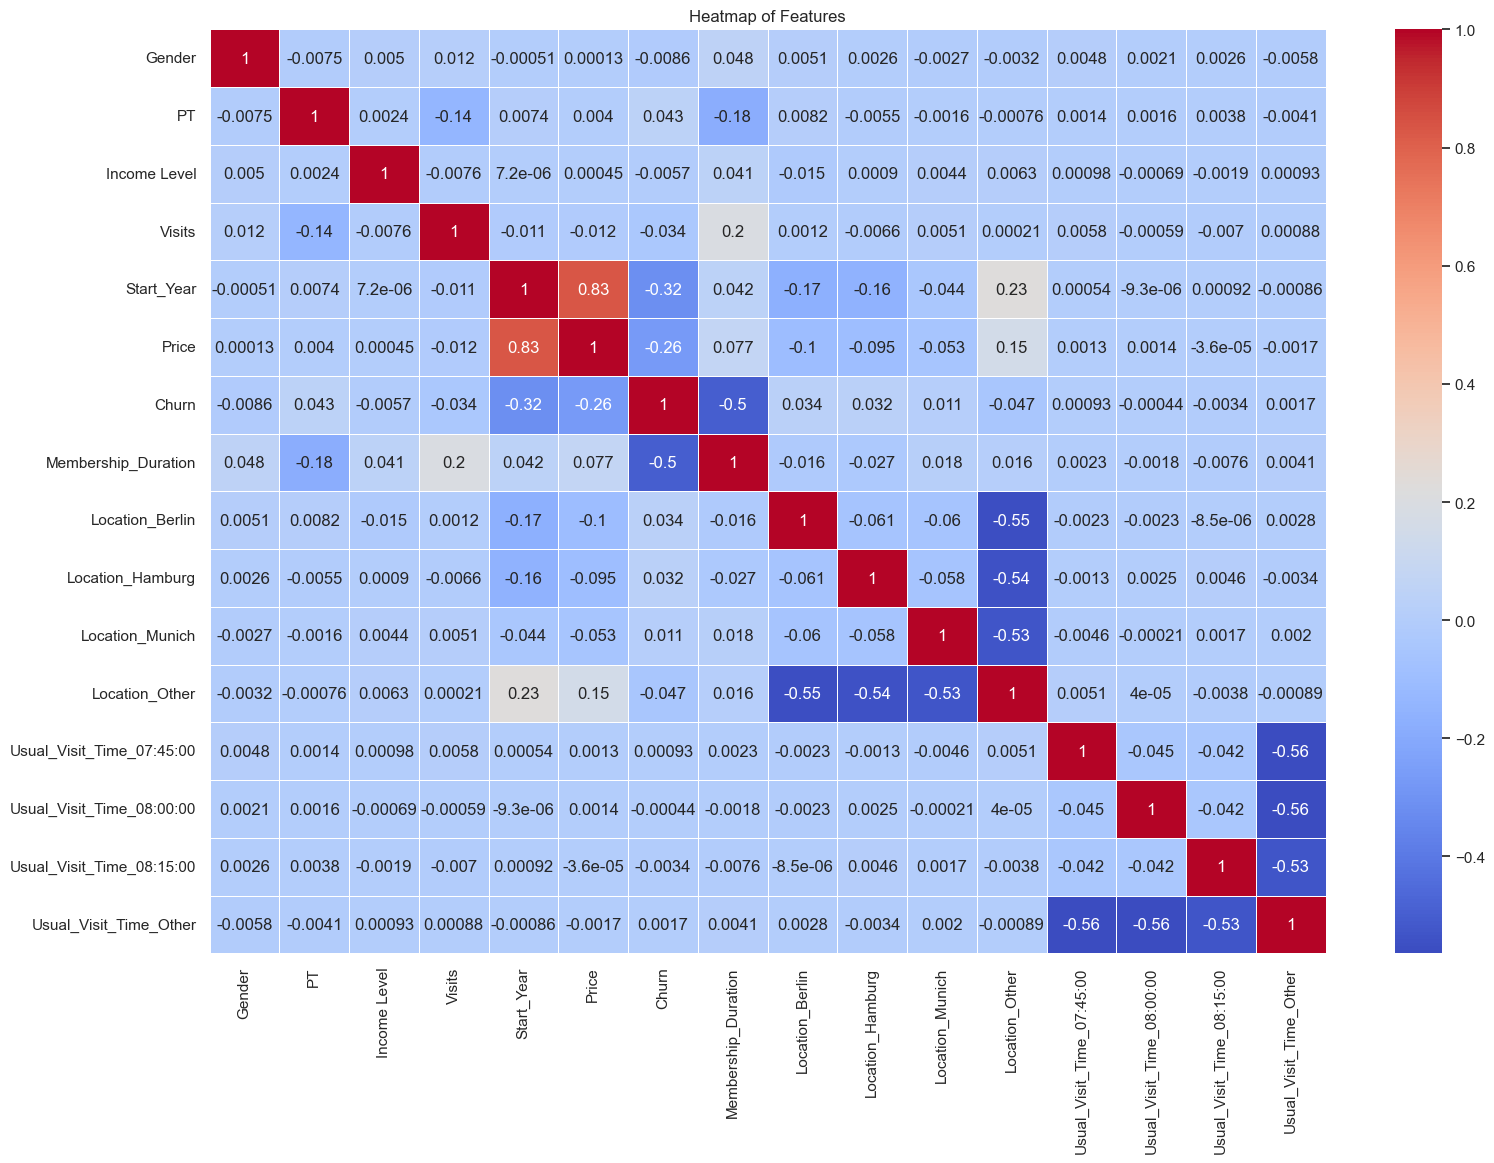

In [264]:
plt.figure(figsize=(18, 12))
sns.heatmap(heatmap_data.corr(), annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Heatmap of Features')
plt.show()

As u can see every column now in the dataset have important in estimating the churn rate note we are talking about the columns in heatmap_data

but we can remove the Id which is not very importent in determining churn rate 

In [265]:
final_merged_data.drop(columns=['ID'],inplace=True)

In [266]:
final_merged_data.sample(3)

,Gender,PT,Income Level,Visits,Start_Year,Price,Churn,Membership_Duration,Location_Berlin,Location_Hamburg,Location_Munich,Location_Other,Usual_Visit_Time_07:45:00,Usual_Visit_Time_08:00:00,Usual_Visit_Time_08:15:00,Usual_Visit_Time_Other
282103,1,0,3,3.0,2010,30.99,1,91.0,1,0,0,0,False,False,False,True
84345,1,0,4,3.0,2010,30.99,1,183.0,0,1,0,0,False,False,False,True
2680510,0,0,4,3.0,2018,36.99,0,456.0,0,0,0,1,False,False,False,True


# Splitting the Data

In [272]:
final_merged_data = final_merged_data[:30000]

In [273]:
X = final_merged_data.drop(columns=['Churn'])
y = final_merged_data['Churn']

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2)
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((24000, 15), (6000, 15), (24000,), (6000,))

# Building the Model

In [274]:
models = {
    'LogisticRegression': LogisticRegression(max_iter=1000),
    'RandomForestClassifier': RandomForestClassifier(),
    'GradientBoostingClassifier': GradientBoostingClassifier()
}

params = {
    'LogisticRegression': {
        'C': [0.01, 0.1, 1, 10, 100],
        'solver': ['liblinear', 'saga']
    },
    'RandomForestClassifier': {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10]
    },
    'GradientBoostingClassifier': {
        'learning_rate': [0.01, 0.1, 0.2],
        'n_estimators': [50, 100, 200],
        'max_depth': [3, 4, 5]
    }
}

In [275]:
best_models = {}
for model_name in models.keys():
    grid_search = GridSearchCV(estimator=models[model_name], param_grid=params[model_name], cv=5, n_jobs=-1, scoring='accuracy')
    grid_search.fit(X_train, y_train)
    best_models[model_name] = grid_search.best_estimator_
    print(f"Best parameters for {model_name}: {grid_search.best_params_}")
    print(f"Best cross-validation accuracy for {model_name}: {grid_search.best_score_}")


Best parameters for LogisticRegression: {'C': 0.1, 'solver': 'liblinear'}
Best cross-validation accuracy for LogisticRegression: 0.9666666666666666
Best parameters for RandomForestClassifier: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 50}
Best cross-validation accuracy for RandomForestClassifier: 1.0
Best parameters for GradientBoostingClassifier: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}
Best cross-validation accuracy for GradientBoostingClassifier: 1.0


In [277]:
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    report = classification_report(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    precision = report.split('\n')[2].split()[1]  # Extract precision from classification report
    recall = report.split('\n')[2].split()[2]     # Extract recall from classification report
    f1_score = report.split('\n')[2].split()[3]   # Extract F1 score from classification report
    
    print("Classification Report:")
    print(report)
    print("Confusion Matrix:")
    print(conf_matrix)
    
    return accuracy, precision, recall, f1_score

model_metrics = {}
for model_name, model in best_models.items():
    print(f"\nEvaluation for {model_name}:")
    accuracy, precision, recall, f1_score = evaluate_model(model, X_test, y_test)
    model_metrics[model_name] = {'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'F1 Score': f1_score}


Evaluation for LogisticRegression:
Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.74      0.76       462
           1       0.98      0.98      0.98      5538

    accuracy                           0.96      6000
   macro avg       0.88      0.86      0.87      6000
weighted avg       0.96      0.96      0.96      6000

Confusion Matrix:
[[ 341  121]
 [  97 5441]]

Evaluation for RandomForestClassifier:
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       462
           1       1.00      1.00      1.00      5538

    accuracy                           1.00      6000
   macro avg       1.00      1.00      1.00      6000
weighted avg       1.00      1.00      1.00      6000

Confusion Matrix:
[[ 462    0]
 [   0 5538]]

Evaluation for GradientBoostingClassifier:
Classification Report:
              precision    recall  f1-score   support

           0

# Answers of Q 2

Do you need to perform any feature engineering before proceeding?

Yes, some feature engineering may be necessary. We've already performed some preprocessing steps like encoding categorical variables and handling missing values. However, additional feature engineering such as creating new features, scaling numerical features, or exploring feature interactions could further enhance model performance.



Do you need to include all variables in the model? Which are the most important ones?

Not necessarily. We've explored the relationships between different variables and identified potentially important features through exploratory data analysis and correlation analysis. From our analysis, we've identified variables like Membership Duration, Visits, Gender, PT (Personal Training), Income Level, and Location as potentially important predictors of churn. However, we may need to conduct feature selection or regularization techniques to determine the most influential variables for our predictive model.



What kind of Machine Learning algorithm should you use?

Based on our analysis so far, logistic regression, random forest, and gradient boosting are promising algorithms for predicting customer churn. Logistic regression provides interpretability, while random forest and gradient boosting can capture complex relationships in the data. We should start with logistic regression due to its simplicity and interpretability, and then explore more complex models if needed. At final go RandomForest and GradientBoostingClassifier perform exceptionally well on only 30000 dataset



Which evaluation metric will you use to assess model performance? How reliable are your results?

For assessing model performance, we can use metrics like accuracy, precision, recall, and F1-score. Since we're dealing with a binary classification problem (churn prediction), these metrics are appropriate for evaluating the model's predictive power.

# End

Thank you so much for this amazing work it was nice working on this dataset